# PROJECT :  FLOWER CLASSIFICATION

In [30]:
# import the packages

import numpy as np
import matplotlib.pyplot as plt
import keras
from skimage import io
import os
import glob
import random
import six
import numpy as np
import resnet

from skimage.morphology import binary_dilation , binary_erosion , binary_opening , binary_closing
from skimage.morphology import selem
from skimage import transform as tf

from keras.models import Model
from keras.layers import Input , Activation , Dense , Flatten
from keras.layers.convolutional import Conv2D , MaxPooling2D , AveragePooling2D
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as k
from keras import optimizers
from keras.callbacks import *

In [2]:
# Function for ploting the images

def plot_image(images , captions = None , cmap = None):
    f , axes = plt.subplots(1 , len(images) , sharey = True)
    f.set_figwidth(15)
    
    for ax , images in zip(axes , images):
        ax.imshow(images , cmap)

## Image Augmentation and Preprocessing

#### Load the dataset

In [3]:
dataset = "./flowers"
flowers_cls = ['daisy' , 'dandelion' , 'rose' , 'sunflower' , 'tulip']

In [4]:
flowers_cls

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
# Now using GLOB find out the all images from it's path

flower_path = os.path.join(dataset , flowers_cls[1] , '*')
print(flower_path)

./flowers\dandelion\*


In [6]:
flower_path = glob.glob(flower_path)
print(flower_path[3])

./flowers\dandelion\10437652486_aa86c14985.jpg


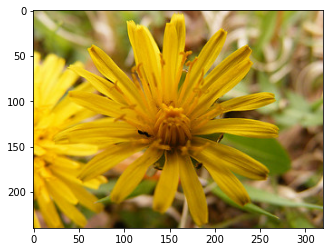

In [7]:
rand_index = random.randint(0 , len(flower_path))
image = io.imread(flower_path[rand_index])
plt.imshow(image)

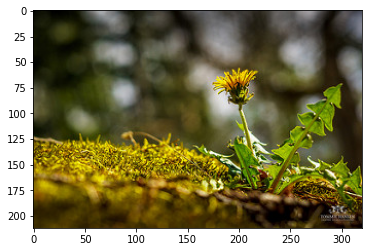

In [8]:
flower_path = os.path.join(dataset , flowers_cls[1] , '*')
flower_path = glob.glob(flower_path)

image = io.imread(flower_path[111])
plt.imshow(image)

In [9]:
image.shape

(212, 320, 3)

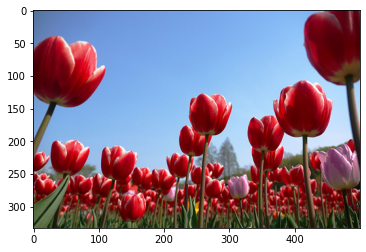

In [10]:
flower_path = os.path.join(dataset , flowers_cls[4] , '*')
flower_path = glob.glob(flower_path)

image = io.imread(flower_path[111])
plt.imshow(image)

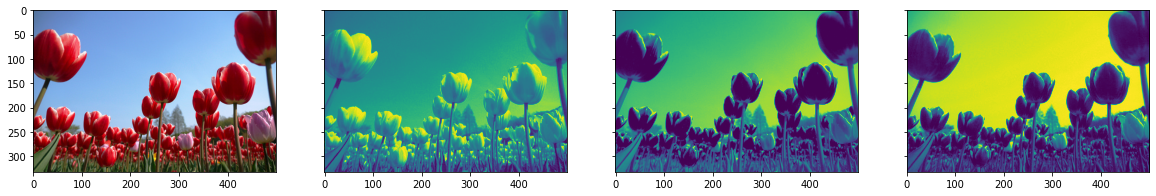

In [11]:
# ploting original image with RGB color

f , (ax1 , ax2 , ax3 , ax4) = plt.subplots(1 , 4 , sharey = True)
f.set_figwidth(20)

ax1.imshow(image)
ax2.imshow(image[: , : , 0])
ax3.imshow(image[: , : , 1])
ax4.imshow(image[: , : , 2])

## Morphological Transformation

### Thresholding

Set a value and convert all the pixels to 1 above that value, and convert 0 which are less than the value.

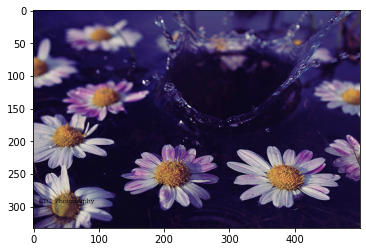

In [12]:
flower_path = os.path.join(dataset , flowers_cls[0] , '*')
flower_path = glob.glob(flower_path)

image = io.imread(flower_path[3])
plt.imshow(image)

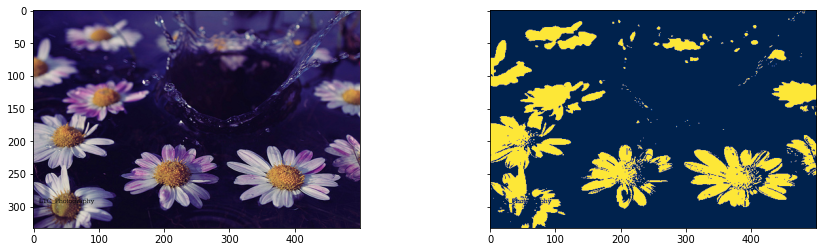

In [13]:
binary_image = image[: , : , 0] > 125
plot_image([image , binary_image] , cmap = 'cividis')

### Erosion , Dilation , Opening , Closing

In [14]:
selem = selem.disk(5)

OPENING is mainly erosion followed by dilation, it remove the small bright spots and connect the small dark spots

CLOSING is opposite of OPENING.It can remove the small dark spots and connect white or bright spots.

In [15]:
open_img = binary_opening(binary_image , selem)
close_img = binary_closing(binary_image , selem)

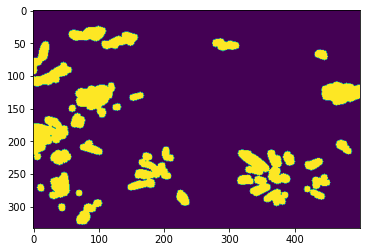

In [16]:
plt.imshow(open_img)

EROSION manily decrease the bright regions.

DILATION is opposite.It shrinks the dark regions.

In [17]:
erod_img = binary_erosion(binary_image , selem)
dilt_img = binary_dilation(binary_image , selem)

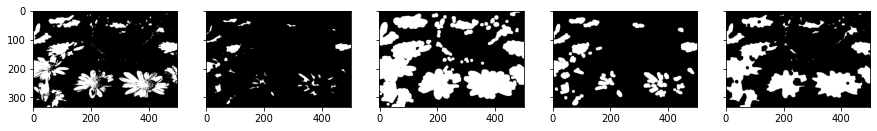

In [18]:
plot_image([binary_image , erod_img  , dilt_img , open_img , close_img] , cmap = 'gray')

## Normalization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


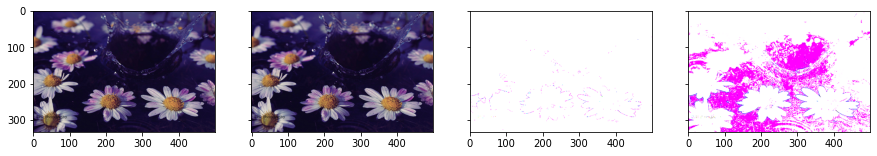

In [19]:
normal_image = image / 255
normal_image2 = image - np.min(image) / np.max(image) - np.min(image)
percentile_image = image - np.percentile(image , 5) / np.percentile(image , 95) - np.percentile(image , 5)

plot_image([image , normal_image , normal_image2 , percentile_image] , cmap = 'bwr')

## Augmentation

Augmentation is done when the quantity of the data is not sufficient.In this project image is not that much for better training.So we need to increase the number of images.Augmentation is increased the number of image by doing Rotation , Enhancing , Flipping , Cropping , Translation , Adding-Noise etc.

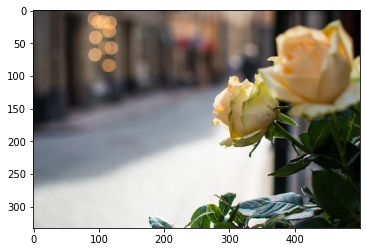

In [20]:
flower_path = os.path.join(dataset , flowers_cls[2] , '*')
flower_path = glob.glob(flower_path)

image = io.imread(flower_path[31])
plt.imshow(image)

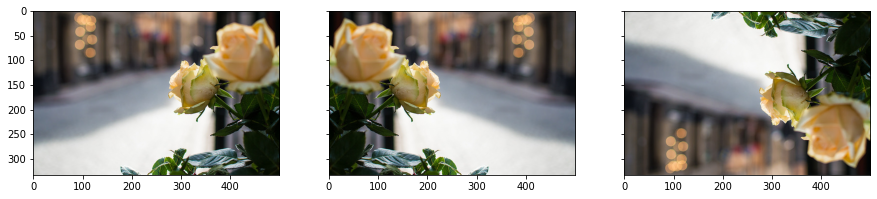

In [21]:
image_flipr = np.fliplr(image)
image_flipd = np.flipud(image)

plot_image([image , image_flipr , image_flipd] , cmap = 'bwr')

In [22]:
## Shifting the image
shift_x , shift_y = image.shape[0]/2 , image.shape[1]/2


## Translation the image
matrix_topleft = tf.SimilarityTransform(translation = [-shift_x , -shift_y])
matrix_center = tf.SimilarityTransform(translation = [shift_x , shift_y])


## Rotate the image
rotate_transform = tf.AffineTransform(rotation = np.deg2rad(45))
rotate_matrix = matrix_topleft + rotate_transform + matrix_center
rotate_image = tf.warp(image , rotate_matrix)


## Scaling the image
scale_transformation = tf.AffineTransform(scale = (2 , 2))
scale_matrix = matrix_topleft + scale_transformation + matrix_center
scale_zoom_out = tf.warp(image , scale_matrix)

scale_transformation = tf.AffineTransform(scale = (0.5 , 0.5))
scale_matrix = matrix_topleft + scale_transformation + matrix_center
scale_zoom_in = tf.warp(image , scale_matrix)


## translation the image
translate_transformation = tf.AffineTransform(translation = (50 , 50))
translate_image = tf.warp(image , translate_transformation)

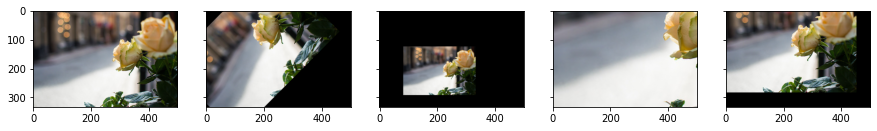

In [23]:
plot_image([image , rotate_image , scale_zoom_out , scale_zoom_in , translate_image] , cmap = 'cividis')

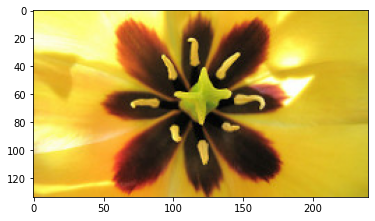

In [24]:
flower_path = os.path.join(dataset , flowers_cls[4] , '*')
flower_path = glob.glob(flower_path)

image = io.imread(flower_path[444])
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


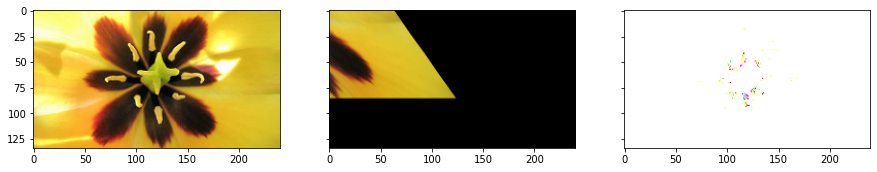

In [25]:
## Adding some Noise to the image

shear_transform = tf.AffineTransform(shear = np.deg2rad(45))
shear_matrix = matrix_topleft + shear_transform + matrix_center
shear_image = tf.warp(image , shear_matrix)

bright_filter = image * 0.999 + np.zeros_like(image) * 0.001

plot_image([image , shear_image , bright_filter])

## Building the Model.

### Data Generator

In [26]:
class datagenerator(keras.utils.Sequence):
    
    def __init__(self , mode = 'train' , ablation = None , flowers_cls = ['daisy' , 'dandelion' , 'rose' , 'sunflower' , 'tulip'],
                 batch_size = 32 , dim = (100 , 100) , n_channels = 3 , shuffle = True):
        
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        for i , cls in enumerate(flowers_cls):
            
            paths = glob.glob(os.path.join(dataset , cls , '*'))
            brk_point = int(len(paths) * 0.8)
            
            if mode == 'train':
                paths = paths[:brk_point]
            
            else:
                paths = paths[brk_points:]
                
            if ablation is not None:
                paths = paths[:ablation]
            
            self.list_IDs += paths
            
            self.labels.update({p:i for p in paths})
            
        
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()
        
        
        def __len__(self):
            ## Determine the number of batches per epoch
            return int(np.floor(len(self.list_IDs) / self.batch_size))
        
        def __getitems__(self , index):
            indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
            
            list_IDs_temp = [self.list_IDs[k] for k in indexes]
            
            X , y = self.__data_generation(list_IDs_temp)
            
            return X , y
        
        def __on_epoch_end(self):
            
            ## Upadate index after each epochs
            self.indexes = np.arange(len(self.list_IDs))
            
            if self.shuffle == True:
                np.random.shuffle(self.indexes)
                
        
        def __data_generation(self , list_IDs_temp):
            
            ## generate data with batch_size sample
            X = np.empty((self.batch_size , *self.dim , self.n_channels))
            y = np.empty((self.batch_size) , dtype = int)
            
            deleted_rows = []
            
            for i , ID in enumerate(list_IDs_temp):
                img = io.imread(ID)
                img = img / 255
                
                if img.shape[0] > 100 and img.shape[1] > 100:
                    h , w , _ = img.shape
                    img = img[int(h/2)-50:int(h/2)+50 , int(w/2)-50:int(w/2)+50, : ]
                
                else:
                    deleted_rows.append(i)
                    continue
                
                X[i,] = img
                y[i] = self.labels[ID]
                
            X = np.delete(X , delete_rows , axis = 0)
            y = np.delete(y , delete_rows , axis = 0)   
            
            return X , keras.utiles.to_categorical(y , num_classes = self.n_classes)

## Ablation

It's a very best way to check wheather the code will work well or not.By checking this try to run some experiment.This is mainly called as ablation.

We take only one epoch and check wheather it run properly or not.

In [27]:
img_channels = 3
img_rows = 100
img_cols = 100
nb_classes = 5

In [28]:
# #import resnet


model = resnet.ResnetBuilder.build_resnet_101((img_channels , img_rows , img_cols) , nb_classes)
model.compile(loss = 'categorical_crossentropy' , optimizer = 'relu' , metrics = ['accuracy'])

training_generator = datagenerator('train' , ablation = 100)
validation_generator = datagenerator('val' , ablation = 100)


model.fit_generator(generator = training_generator , validation_data = validation_generator , epoch = 1)

ValueError: Operands could not be broadcast together with shapes (1, 25, 64) (1, 25, 256)

### Keras Callbacks

Callbacks is a specific function to apply a some specific tasks. Callbacks are basically actions that are performed in training section. 

In [37]:
hyper_param = [0.1 , 0.01 , 0.001]


class Losshistory(keras.callbacks.Callback):
    
    def on_train_begin(self , logs = {}):
        self.losses = []
        
    def on_batch_end(self , batch , logs = {}):
        self.losses.append(logs.get('loss'))
        
        

history = Losshistory()
plot_data = {}


for i in hyper_param:
    print('\n\n'+'==' *20 + ' checking for LR = {} '.format(i) + '=='*20)
    sgd = optimizers.SGD(lr = i , clipnorm = 1.)
    
    model = resnet.ResnetBuilder.build_resnet_18((img_channels , img_rows , img_cols) , nb_classes)
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'relu' , metrics = ['accuracy'])

    training_generator = datagenerator('train' , ablation = 100)
    validation_generator = datagenerator('val' , ablation = 100)


    model.fit_generator(generator = training_generator , validation_data = validation_generator , epoch = 3 , callbacks = [history])
    
    plot_data[i] = history.losses



======================================== checking for LR = 0.1 ========================================


ValueError: Stride must be > 0, but got 0 for 'conv2d_16/convolution' (op: 'Conv2D') with input shapes: [?,1,25,64], [1,1,64,1].

AttributeError: 'Figure' object has no attribute 'set_width'

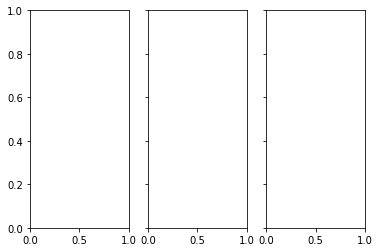

In [41]:
## plot the losses

f , axes = plt.subplots(1 , 3 , sharey = True)
f.set_width(15)

plt.setp(axes , xticks = np.arange(0 , len(plot_data[0.01]) , 1) + 1)

for i , lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr])) + 1 , plot_data[lr])

### Apply DecayLR callbacks

In [43]:
class DecayLr(keras.callbacks.Callback):
    
    def __init__(self , base_lr = 0.01 , decay_epoch = 1):
        super(DecayLr , self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history = []
        
        
    def on_train_begin(self , logs = {}):
        k.set_value(self.model.optimizers.lr , self.base_lr)
        
    
    def on_epoch_end(self , epoch , logs = {}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(k.get_value(self.model.optimizers.lr))
        k.set_value(self.model.optimizers.lr , new_lr)
        


        
history = Losshistory()
plot_data = {}

decay = DecayLr(base_lr = 0.1)

sgd = optimizers.SGD()

model = resnet.ResnetBuilder.build_resnet_18((img_channels , img_rows , img_cols) , nb_classes)
model.compile(loss = 'categorical_crossentropy' , optimizer = sgd , metrics = ['accuracy'])

training_generator = datagenerator('train' , ablation = 100)
validation_generator = datagenerator('val' , ablation = 100)


model.fit_generator(generator = training_generator , validation_data = validation_generator , epoch = 3 , callbacks = [history , decay])
    
plot_data[lr] = decay.lr_history

ValueError: Stride must be > 0, but got 0 for 'conv2d_24/convolution' (op: 'Conv2D') with input shapes: [?,1,25,64], [1,1,64,1].